In [1]:
import argparse
import json
import math
import os
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import BertTokenizerFast
from tqdm import tqdm

In [2]:

# -----------------------------
# Utilities
# -----------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:

# -----------------------------
# Layers: RMSNorm, SwiGLU, RoPE, MultiHeadAttention
# -----------------------------

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor):
        # x: (B, T, D)
        norm = x.pow(2).mean(-1, keepdim=True).add(self.eps).sqrt()
        return x / norm * self.scale


class FFNSwiGLU(nn.Module):
    def __init__(self, dim: int, hidden_dim: int):
        super().__init__()
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(dim, hidden_dim, bias=False)
        self.w_out = nn.Linear(hidden_dim, dim, bias=False)

    def forward(self, x: torch.Tensor):
        return self.w_out(F.silu(self.w2(x)) * self.w1(x))


def rotate_every_two(x):
    # x: (..., dim)
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    return torch.stack((-x2, x1), dim=-1).reshape_as(x)


def apply_rotary_pos_emb(x: torch.Tensor, sin: torch.Tensor, cos: torch.Tensor):
    # x: (B, T, n_heads, head_dim)
    return (x * cos) + (rotate_every_two(x) * sin)


In [4]:
class RoPEMultiHeadedAttention(nn.Module):
    def __init__(self, emb_dim: int, n_heads: int, max_seq_len: int = 1024, causal: bool = True):
        super().__init__()
        assert emb_dim % n_heads == 0
        self.emb_dim = emb_dim
        self.n_heads = n_heads
        self.head_dim = emb_dim // n_heads
        self.causal = causal

        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=False)

        # precompute sin/cos for RoPE
        inv_freq = 1.0 / (10000 ** (torch.arange(0, self.head_dim, 2).float() / self.head_dim))
        t = torch.arange(max_seq_len).float()
        freqs = torch.einsum('i , j -> i j', t, inv_freq)  # (T, head_dim/2)
        emb_sin = torch.sin(freqs)
        emb_cos = torch.cos(freqs)
        # reshape to (T, 1, 1, head_dim) -> expand when using
        sin = torch.repeat_interleave(emb_sin, repeats=2, dim=-1)
        cos = torch.repeat_interleave(emb_cos, repeats=2, dim=-1)
        # sin, cos shape: (T, head_dim)
        self.register_buffer('sin', sin)  # (T, head_dim)
        self.register_buffer('cos', cos)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        # x: (B, T, D)
        B, T, D = x.shape
        q = self.q_proj(x).view(B, T, self.n_heads, self.head_dim)
        k = self.k_proj(x).view(B, T, self.n_heads, self.head_dim)
        v = self.v_proj(x).view(B, T, self.n_heads, self.head_dim)

        # apply RoPE to q and k
        sin = self.sin[:T].to(x.device)  # (T, head_dim)
        cos = self.cos[:T].to(x.device)
        # reshape sin/cos to (T, 1, 1, head_dim)

        sin = sin.unsqueeze(0).unsqueeze(2) # (1, T, 1, head_dim) - CORRECT
        cos = cos.unsqueeze(0).unsqueeze(2) # (1, T, 1, head_dim) - CORRECT

        q = apply_rotary_pos_emb(q, sin, cos)
        k = apply_rotary_pos_emb(k, sin, cos)

        # compute attention
        # transpose to (B, n_heads, T, head_dim)
        q_t = q.permute(0, 2, 1, 3)
        k_t = k.permute(0, 2, 1, 3)
        v_t = v.permute(0, 2, 1, 3)

        scores = torch.matmul(q_t, k_t.transpose(-2, -1)) / math.sqrt(self.head_dim)
        # mask: (B, T) boolean where True means keep
        if mask is not None:
            mask = mask.to(scores.device)
            mask = mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,T)
            scores = scores.masked_fill(~mask, float('-inf'))

        if self.causal:
            # causal mask
            causal_mask = torch.triu(torch.ones(T, T, device=scores.device), diagonal=1).bool()
            scores = scores.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v_t)  # (B, n_heads, T, head_dim)
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, D)
        out = self.out_proj(out)
        return out, attn


In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, emb_dim: int, ffn_dim: int, n_heads: int, max_seq_len: int = 1024):
        super().__init__()
        self.attn = RoPEMultiHeadedAttention(emb_dim, n_heads, max_seq_len=max_seq_len, causal=True)
        self.input_ln = RMSNorm(emb_dim)
        self.ffn_ln = RMSNorm(emb_dim)
        self.ffn = FFNSwiGLU(emb_dim, ffn_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        y = self.input_ln(x)
        y_attn, _ = self.attn(y, mask=mask)
        x = x + y_attn
        z = self.ffn_ln(x)
        z = self.ffn(z)
        x = x + z
        return x

In [ ]:
class TransformerPlusPlus(nn.Module):
    def __init__(self, n_layers: int, vocab_size: int, emb_dim: int, ffn_dim: int, n_heads: int, max_seq_len: int = 512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.layers = nn.ModuleList([DecoderBlock(emb_dim, ffn_dim, n_heads, max_seq_len=max_seq_len) for _ in range(n_layers)])
        self.final_ln = RMSNorm(emb_dim)
        self.output = nn.Linear(emb_dim, vocab_size, bias=False)

    def forward(self, tokens: torch.Tensor, mask: torch.Tensor = None):
        # tokens: (B, T)
        x = self.embed(tokens)  # (B, T, D)
        for l in self.layers:
            x = l(x, mask=mask)
        x = self.final_ln(x)
        # predict next token from last position
        logits = self.output(x[:, -1, :])
        return logits

In [ ]:
# -----------------------------
# Dataset: load wikitext-2 and prepare samples
# -----------------------------

class NextTokenDataset(Dataset):
    def __init__(self, encodings: List[List[int]], seq_len: int = 64):
        # encodings: list of token id lists (each is a sequence / document)
        self.encodings = encodings
        self.seq_len = seq_len

    def __len__(self):
        return sum(max(1, len(x) - 1) for x in self.encodings)

    def __getitem__(self, idx):
        # naive indexing: randomly select a document then a random start
        # For reproducibility we map idx to a doc and offset
        # Build cumulative lengths
        # Simpler: randomly choose document and start in __getitem__ (works for DataLoader shuffling)
        doc = random.choice(self.encodings)
        if len(doc) < 2:
            return torch.tensor([0]), torch.tensor(0)
        start = random.randint(0, max(0, len(doc) - 2))
        end = min(len(doc) - 1, start + self.seq_len)
        sent = doc[start:end]
        nxt = doc[end]
        return torch.tensor(sent, dtype=torch.long), torch.tensor(nxt, dtype=torch.long)


def collate_fn(batch):
    # batch: list of (tensor(seq), tensor(next))
    seqs, nxts = zip(*batch)
    lengths = [s.size(0) for s in seqs]
    max_len = max(lengths)
    padded = torch.full((len(seqs), max_len), fill_value=0, dtype=torch.long)
    for i, s in enumerate(seqs):
        padded[i, : s.size(0)] = s
    nxts = torch.stack(nxts)
    # mask where token>0 (non-pad)
    mask = padded != 0
    return padded, nxts, mask






In [ ]:
# -----------------------------
# Training & evaluation
# -----------------------------

def train_epoch(model, device, data_loader, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for tokens, next_tokens, mask in tqdm(data_loader, desc='train'):
        tokens = tokens.to(device)
        next_tokens = next_tokens.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        logits = model(tokens, mask=mask)
        loss = F.cross_entropy(logits, next_tokens)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=-1)
        total += tokens.size(0)
        total_loss += loss.item() * tokens.size(0)
        total_correct += (preds == next_tokens).sum().item()
    return total_loss / total, total_correct / total


@torch.no_grad()
def eval_epoch(model, device, data_loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for tokens, next_tokens, mask in tqdm(data_loader, desc='eval'):
        tokens = tokens.to(device)
        next_tokens = next_tokens.to(device)
        mask = mask.to(device)
        logits = model(tokens, mask=mask)
        loss = F.cross_entropy(logits, next_tokens)
        preds = logits.argmax(dim=-1)
        total += tokens.size(0)
        total_loss += loss.item() * tokens.size(0)
        total_correct += (preds == next_tokens).sum().item()
    return total_loss / total, total_correct / total

# -----------------------------
# Simple sampling (greedy) using trained model
# -----------------------------
@torch.no_grad()
def sample(model, tokenizer, device, prompt: str, max_new_tokens: int = 32):
    model.eval()
    tokens = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=128)['input_ids'].to(device)[0]
    for _ in range(max_new_tokens):
        inp = tokens.unsqueeze(0)  # (1, T)
        mask = inp != 0
        logits = model(inp, mask=mask)
        next_id = logits.argmax(dim=-1)
        tokens = torch.cat([tokens, next_id], dim=0)
    return tokenizer.decode(tokens.cpu().numpy(), skip_special_tokens=True)



In [ ]:
# main.py file for the running model : configuration

class Config:
    """
    Setting Cofiguration of the model
    """
    epochs : int = 1
    batch_size: int = 32
    lr: float = 1e-3
    seq_len: int = 64
    n_layers: int = 4
    emb_dim: int = 256
    ffn_dim: int = 512
    n_heads: int = 4
    max_seq_len: int = 512
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    outdir: str = './checkpoints_tiny_llama'
    seed: int = 42




In [ ]:
# 1. Setup Environment
args = Config()
set_seed(args.seed)
device = torch.device(args.device if torch.cuda.is_available() and 'cuda' in args.device else 'cpu')
os.makedirs(args.outdir, exist_ok=True)
print(f"Using device: {device}")
print(f"Config: {args}")

Using device: cuda
Config: <__main__.Config object at 0x7d0628003c50>


In [ ]:
# 2. Load Tokenizer and Dataset
print('Loading tokenizer and dataset...')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
ds_train = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
ds_valid = load_dataset('wikitext', 'wikitext-2-raw-v1', split='validation')

Loading tokenizer and dataset...


In [ ]:
# 3. Tokenize Data
# We filter out empty lines during mapping
def tok_line(example):
    out = tokenizer(example['text'], add_special_tokens=False)
    # Filter empty lines
    if len(out['input_ids']) > 2:
        return {'ids': out['input_ids']}
    else:
        return {'ids': []} # Return empty list to be filtered

In [ ]:
# Filter short/empty sequences during mapping
ds_train = ds_train.map(tok_line, remove_columns=ds_train.column_names).filter(lambda x: len(x['ids']) > 0)
ds_valid = ds_valid.map(tok_line, remove_columns=ds_valid.column_names).filter(lambda x: len(x['ids']) > 0)

train_enc = [x['ids'] for x in ds_train]
valid_enc = [x['ids'] for x in ds_valid]

print(f'Train docs: {len(train_enc)}, Valid docs: {len(valid_enc)}')


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors


Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

Train docs: 23585, Valid docs: 2450


In [ ]:
# 4. Create Datasets and DataLoaders
train_dataset = NextTokenDataset(train_enc, seq_len=args.seq_len)
valid_dataset = NextTokenDataset(valid_enc, seq_len=args.seq_len)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)

vocab_size = tokenizer.vocab_size
print(f'Vocab size: {vocab_size}')


Vocab size: 30522


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# 5. Initialize Model and Optimizer
model = TransformerPlusPlus(
    n_layers=args.n_layers,
    vocab_size=vocab_size,
    emb_dim=args.emb_dim,
    ffn_dim=args.ffn_dim,
    n_heads=args.n_heads,
    max_seq_len=args.max_seq_len
)
model.to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters.")

optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)

Model created with 18.25M parameters.


In [ ]:
# 6. Training Loop
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'eval_loss': [], 'eval_acc': []}

for epoch in range(1, args.epochs + 1):
    print(f'=== Epoch {epoch}/{args.epochs} ===')
    train_loss, train_acc = train_epoch(model, device, train_loader, optimizer)
    eval_loss, eval_acc = eval_epoch(model, device, valid_loader)
    print(f'Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}; eval_loss={eval_loss:.4f}, eval_acc={eval_acc:.4f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['eval_loss'].append(eval_loss)
    history['eval_acc'].append(eval_acc)

    # save best
    if eval_acc > best_acc:
        best_acc = eval_acc
        torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'eval_acc': eval_acc}, os.path.join(args.outdir, 'best.pt'))
        print('Saved best checkpoint')

    # periodic save
    torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, os.path.join(args.outdir, f'ckpt_epoch_{epoch}.pt'))



=== Epoch 1/1 ===


eval: 100%|██████████| 7381/7381 [01:07<00:00, 108.78it/s]


Epoch 1: train_loss=2.3670, train_acc=0.6783; eval_loss=3.0762, eval_acc=0.6442
Saved best checkpoint


In [ ]:
# 7. Save Final Results
with open(os.path.join(args.outdir, 'training_history.json'), 'w') as f:
    json.dump(history, f)

torch.save(model.state_dict(), os.path.join(args.outdir, 'final_model.pt'))
print('Training complete. Best eval acc:', best_acc)

Training complete. Best eval acc: 0.6442026377627708


In [ ]:
# 8. Run a quick sample
prompt = "In the beginning"
print('\n--- SAMPLING ---')
print(f'Prompt: "{prompt}"')
print('Sample:', sample(model, tokenizer, device, prompt, max_new_tokens=32))


--- SAMPLING ---
Prompt: "In the beginning"
Sample: in the beginning. " ", and the first, and the first, and the first, and the first, and the first, and the first, and the first,


In [ ]:
# 8. Run a quick sample
prompt = "Allah"
print('\n--- SAMPLING ---')
print(f'Prompt: "{prompt}"')
print('Sample:', sample(model, tokenizer, device, prompt, max_new_tokens=32))


--- SAMPLING ---
Prompt: "Allah"
Sample: allah. " " " " " ". " " " " " ". " " " " " ". " " " " " ". " " "


In [ ]:
# 8. Run a quick sample
prompt = "begin"
print('\n--- SAMPLING ---')
print(f'Prompt: "{prompt}"')
print('Sample:', sample(model, tokenizer, device, prompt, max_new_tokens=32))


--- SAMPLING ---
Prompt: "begin"
Sample: begin. " " " " ". the, and the first, and the first, and the first, and the first, and the first, and the first


In [ ]:
# visualization
import json
import matplotlib.pyplot as plt
import os

outdir = args.outdir
history_path = os.path.join(outdir, 'training_history.json')

with open(history_path, 'r') as f:
        history = json.load(f)

epochs = range(1, len(history['train_loss']) + 1)

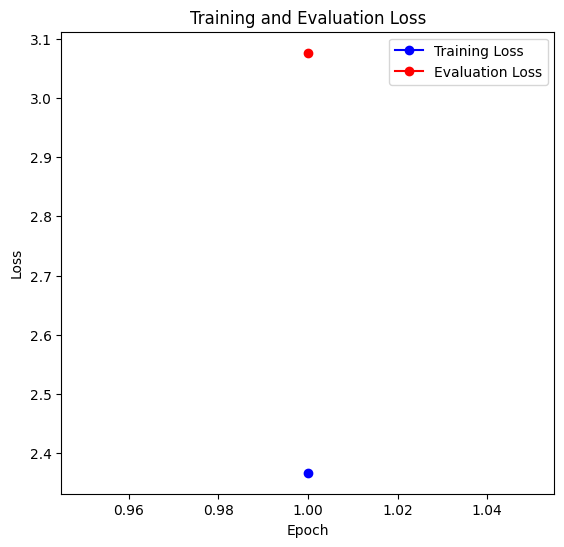

In [ ]:
plt.figure(figsize=(14, 6))

# Plot 1: Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history['eval_loss'], 'ro-', label='Evaluation Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

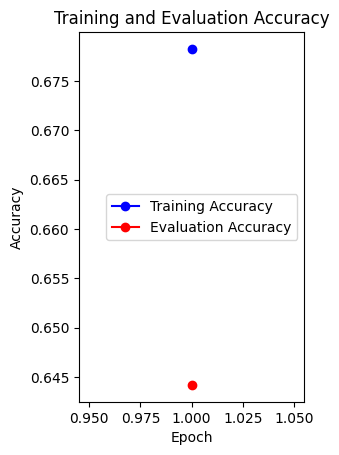

In [ ]:
# Plot 2: Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history['eval_acc'], 'ro-', label='Evaluation Accuracy')
plt.title('Training and Evaluation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Conclusion
Problems :
1. code is written in  vectorized form so we can do parallel processing onto the cpu of data and because its not using complete resources of cpu and gpu.
2. better training data and larger number of epochs we can train to learn more information about the text generation rather than random text.